In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_5880/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import copy
import hist
from coffea import util
import numpy as np
import itertools
import pandas as pd
import uproot
import mplhep as hep

# Directory Info

In [3]:
btagDir = 'MediumBTag/'   #'LooseBTag/'
btagType = 'CSVV2/'
yearDir = '2016/'

APVDir = {
    'preVFP': 'APV/',
    'postVFP': 'noAPV/'
}

od = ''
oddir = ''
if btagDir == '':
    od = '_oldANdisc'
    oddir = 'Old2016_MediumBTag/'
    
MR = ''#'_MistagOnly'

# Systematic Correction / Uncertainty Label
## Set the strings accordingly
#### For bTagSyst: '_btagUnc_\<syst\>' where \<syst\> can be either $central$, $up$ or $down$

In [4]:
Unc = '_btagUnc_central_method2' #_btagUnc_central_method2
contamRemoved = True
mistagWgtsOnly = False
UncDir = Unc + '/'

# Load All Data Eras

In [5]:
import LoadData as LD

JetHT2016_unweighted = LD.JetHT_Unweighted('MediumBTag', 2016)
JetHT2016_weighted = LD.JetHT_Weighted('MediumBTag', 2016, contamRemoved, Unc, mistagWgtsOnly)

In [6]:
# ---- Total Number of Events In JetHT Datasets = 625441538; from dasgoclient ---- #
LD.Cutflow(JetHT2016_weighted)

------- Data Sum of Cutflows --------
          all events :  625441538
                sumw :  625441538
               sumw2 :  625441538
  Passed MET Filters :  594489591
   Passed Trigger(s) :   67343846
       Passed HT Cut :   59431047
 Passed Loose Jet ID :   59431047
     Passed pT,y Cut :   59431047
         >= oneTTbar :   32258385
     Passed dPhi Cut :   32163720
        Good Subjets :   31387979
          AT&Pt0bcen :      46407
          AT&Pt0bfwd :      45148
          AT&Pt1bcen :      40900
          AT&Pt1bfwd :      42794
          AT&Pt2bcen :      11195
          AT&Pt2bfwd :      11368
             at0bcen :    1220500
             at0bfwd :    1254202
             at1bcen :     901495
             at1bfwd :     993048
             at2bcen :     178583
             at2bfwd :     203649
           pret0bcen :     322227
           pret0bfwd :     322042
           pret1bcen :     257496
           pret1bfwd :     278259
           pret2bcen :      58447
          

# Load All MC

In [7]:
import LoadMC as LM

TTbar2016_unweighted = LM.TTbar_Unweighted('MediumBTag', 2016)
QCD2016_unweighted = LM.QCD_Unweighted('MediumBTag', 2016)
DM2016_unweighted = LM.DM_Unweighted('MediumBTag', 2016)
RSGluon2016_unweighted = LM.RSGluon_Unweighted('MediumBTag', 2016)

TTbar2016_weighted = LM.TTbar_Weighted('MediumBTag', 2016, contamRemoved, Unc, mistagWgtsOnly)
QCD2016_weighted = LM.QCD_Weighted('MediumBTag', 2016, contamRemoved, Unc, mistagWgtsOnly)
DM2016_weighted = LM.DM_Weighted('MediumBTag', 2016, contamRemoved, Unc, mistagWgtsOnly)
RSGluon2016_weighted = LM.RSGluon_Weighted('MediumBTag', 2016, contamRemoved, Unc, mistagWgtsOnly)

In [8]:
# LM.Cutflow(DM2016_weighted)

# Stuff for Plotting

In [9]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
import HelpfulPlottingDefs as hpd
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["AT&Pt", "at", "pret", "0t", "1t", ">=1t", "2t", ">=0t"] 
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
list_of_bcats = [ b+y for b,y in itertools.product( btagcats, ycats) ]
label_cats_dict = {i: label for i, label in enumerate(list_of_cats)}

In [10]:
maindirectory = os.getcwd() 
print(maindirectory)

/home/cms-jovyan/TTbarAllHadUproot


# Luminosities, Cross Sections & Scale Factors

In [11]:
Lum2016 = 35920. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable
# Lum2017 = 41530.
# Lum2018 = 59740.
# Lum     = 137190.

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 0.7
qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb
Lum = {
    'preVFP': 19800.,
    'postVFP': 16128.
}


# =========== SF =========== #
ttbar2016_sf = {}
DM2016_sf, RSGluon2016_sf = {}, {}
qcd2016_sf = {}

for vfp in ['preVFP', 'postVFP']:
    ttbar2016_sf[f'700_1000_{vfp}'] = Lum[vfp]*ttbar_xs1*toptag_sf**2*toptag_kf/TTbar2016_unweighted[f'700_1000_{vfp}']['cutflow']['sumw']
    ttbar2016_sf[f'1000_Inf_{vfp}'] = Lum[vfp]*ttbar_xs2*toptag_sf**2*toptag_kf/TTbar2016_unweighted[f'1000_Inf_{vfp}']['cutflow']['sumw']
    qcd2016_sf[vfp] = Lum[vfp]*qcd_xs/QCD2016_unweighted[vfp]['cutflow']['sumw']
    for mass in range(1000, 5500, 500):
        DM2016_sf[str(mass)+'_'+vfp] = Lum[vfp]/DM2016_unweighted[str(mass)+'_'+vfp]['cutflow']['sumw']
        RSGluon2016_sf[str(mass)+'_'+vfp] = Lum[vfp]/RSGluon2016_unweighted[str(mass)+'_'+vfp]['cutflow']['all events']

# Bkg. Est. Shape Closure Test

### Plotting Options

In [12]:
list_of_hists = ['probept', 'probep']
apvdir = '' #APVDir['preVFP']
saveOn = False

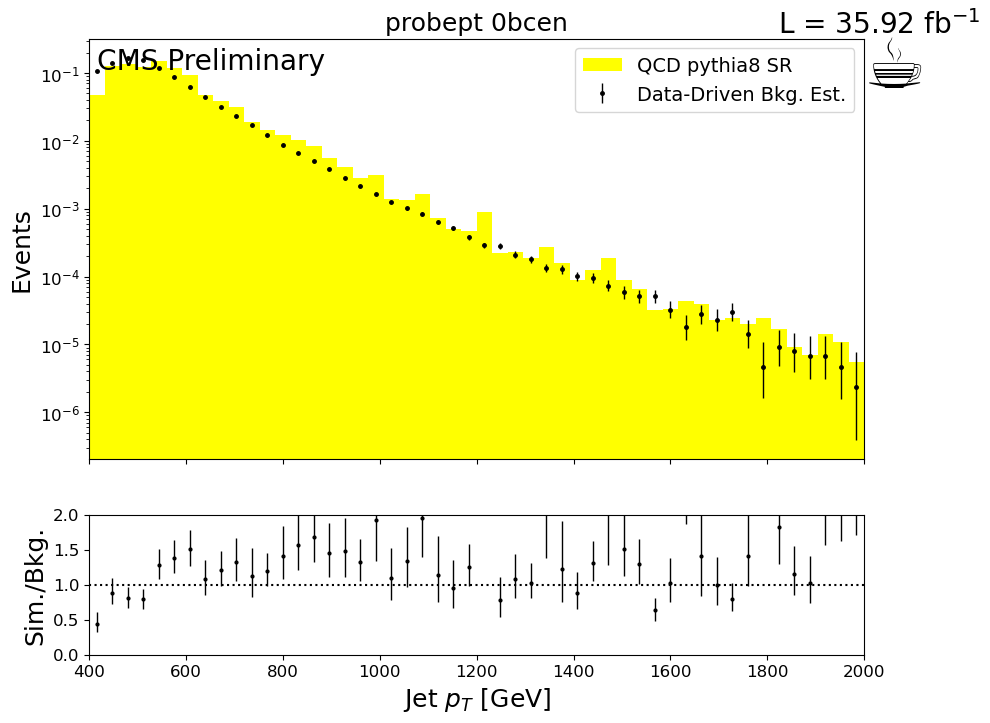

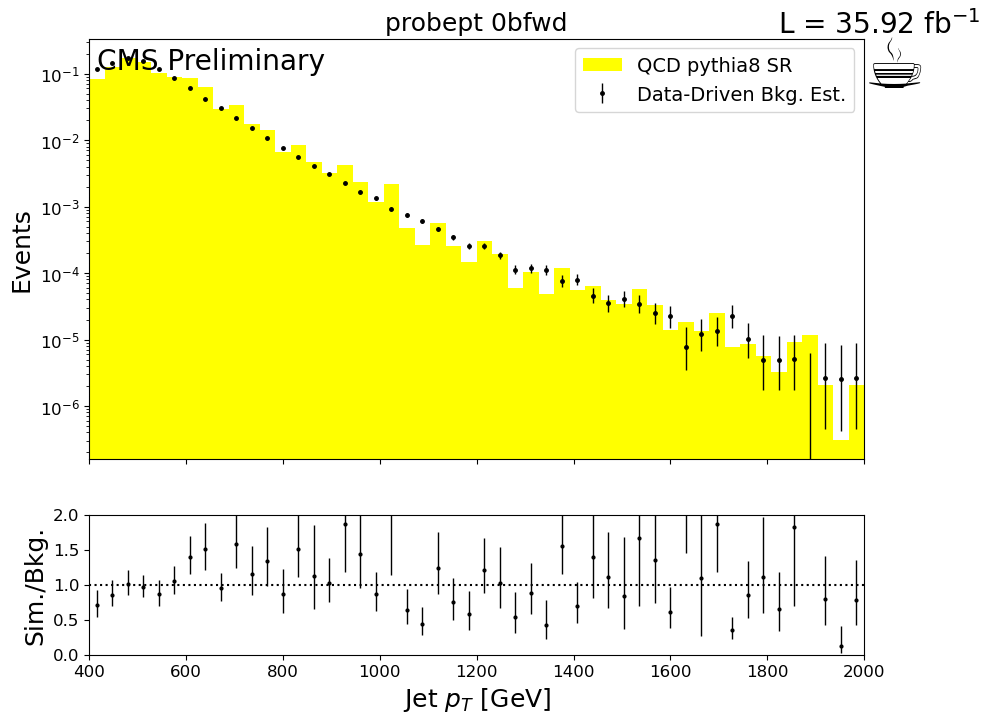

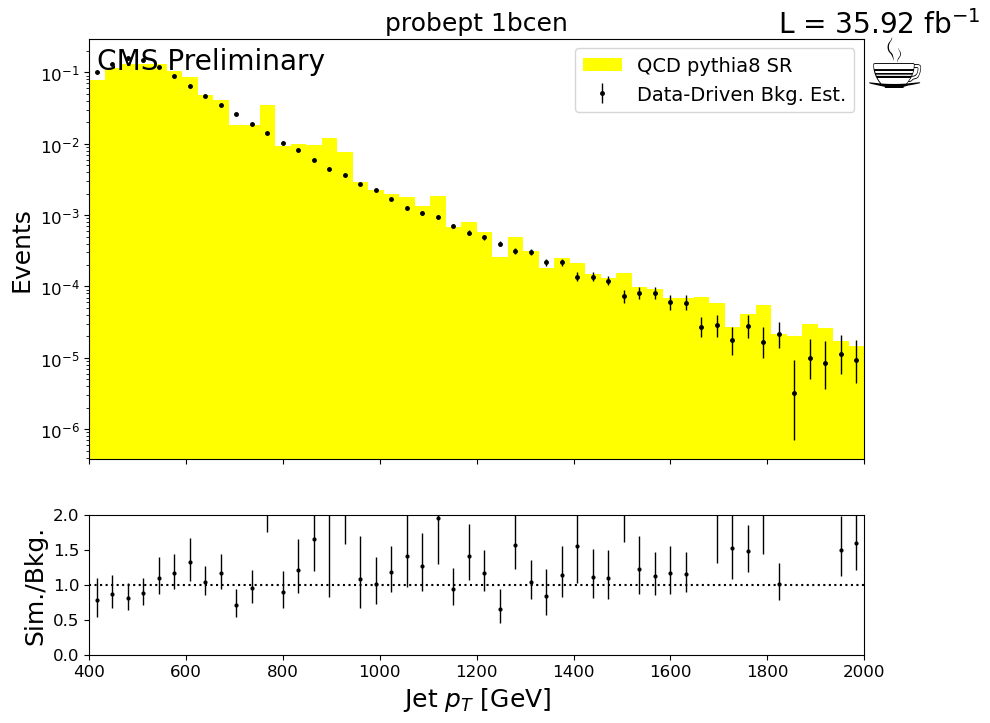

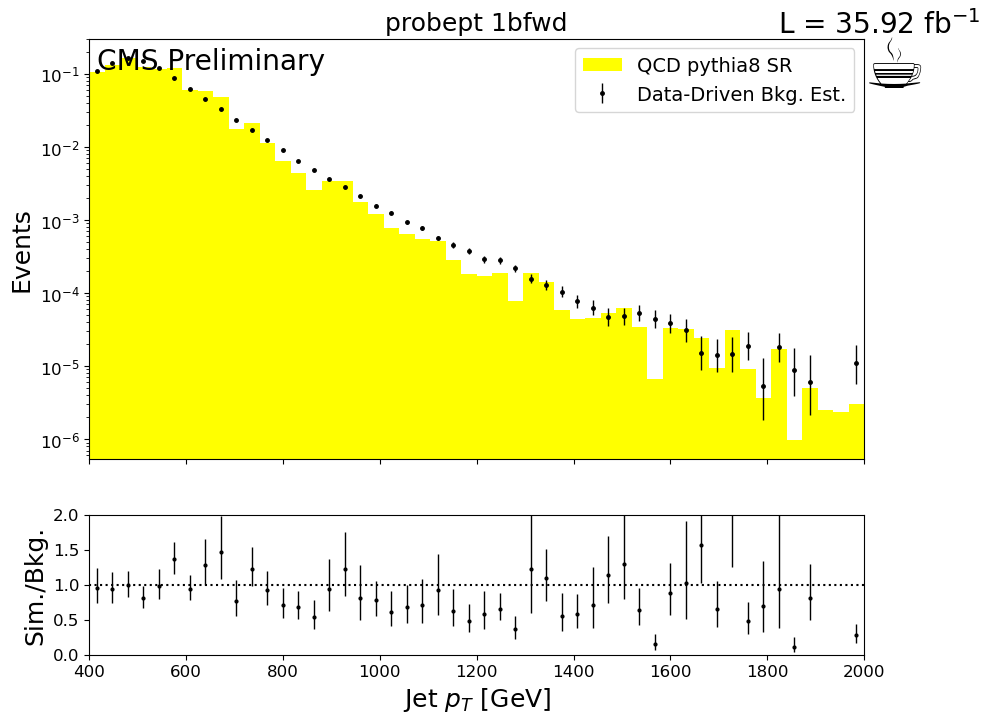

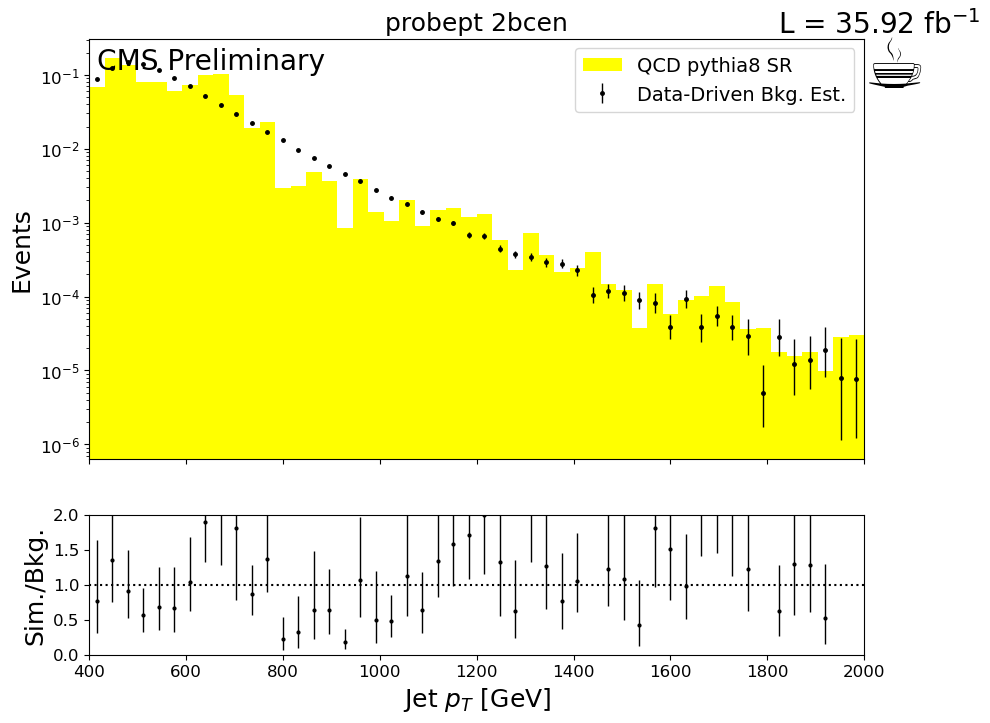

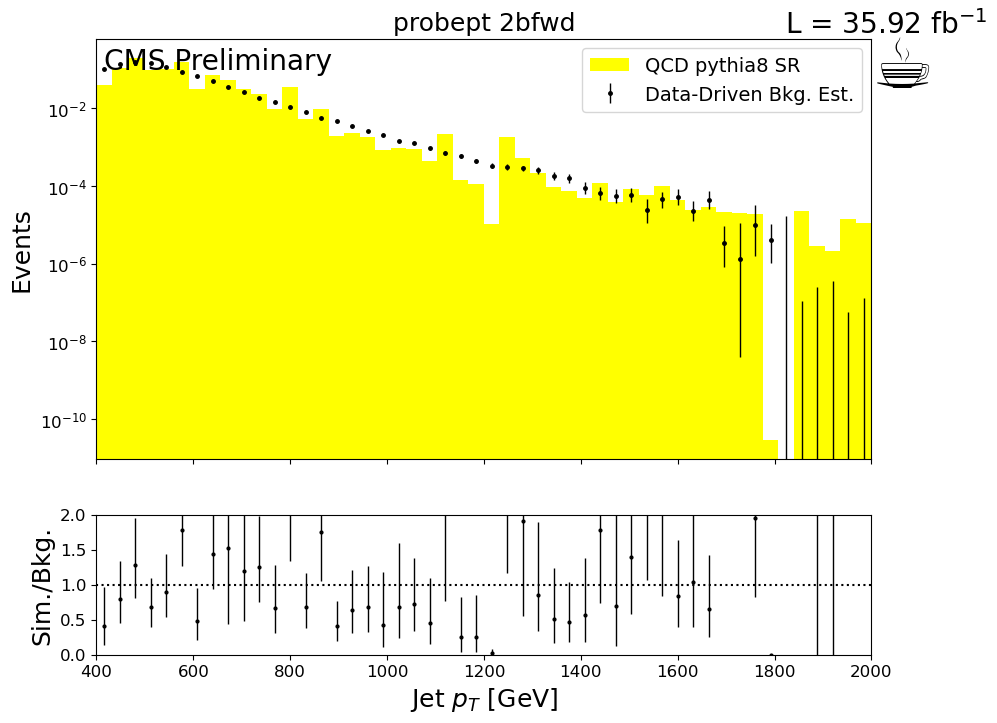

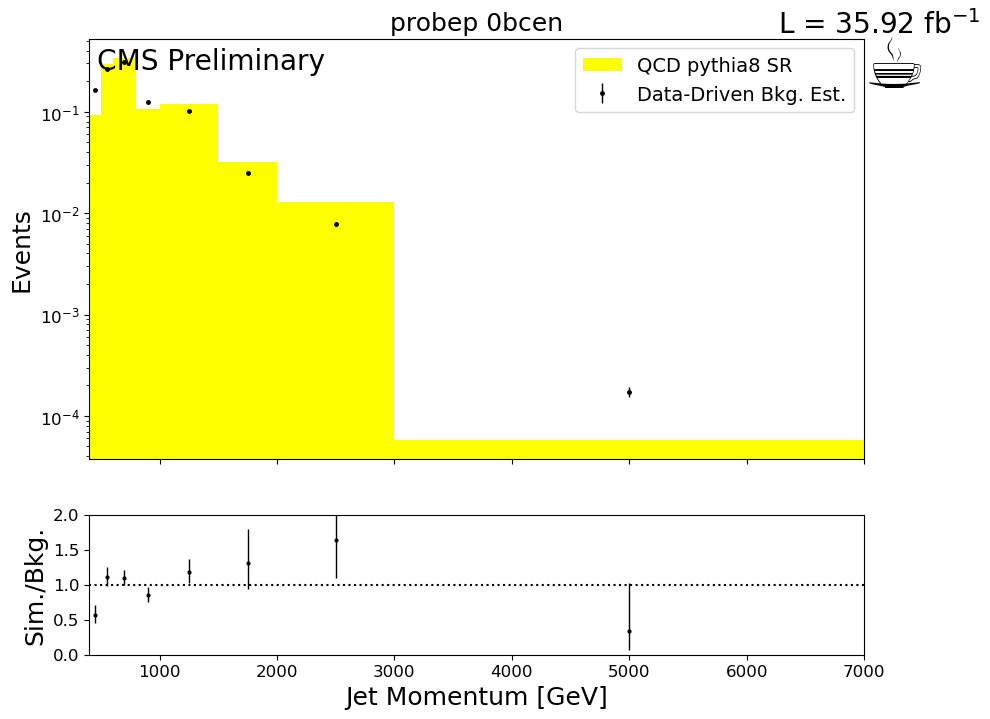

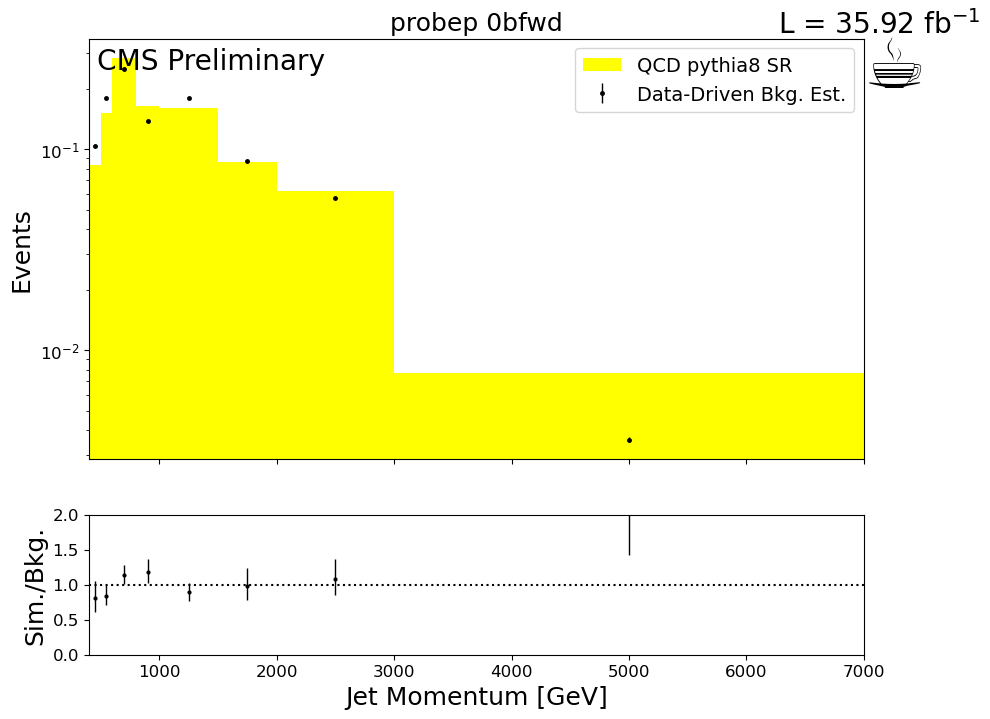

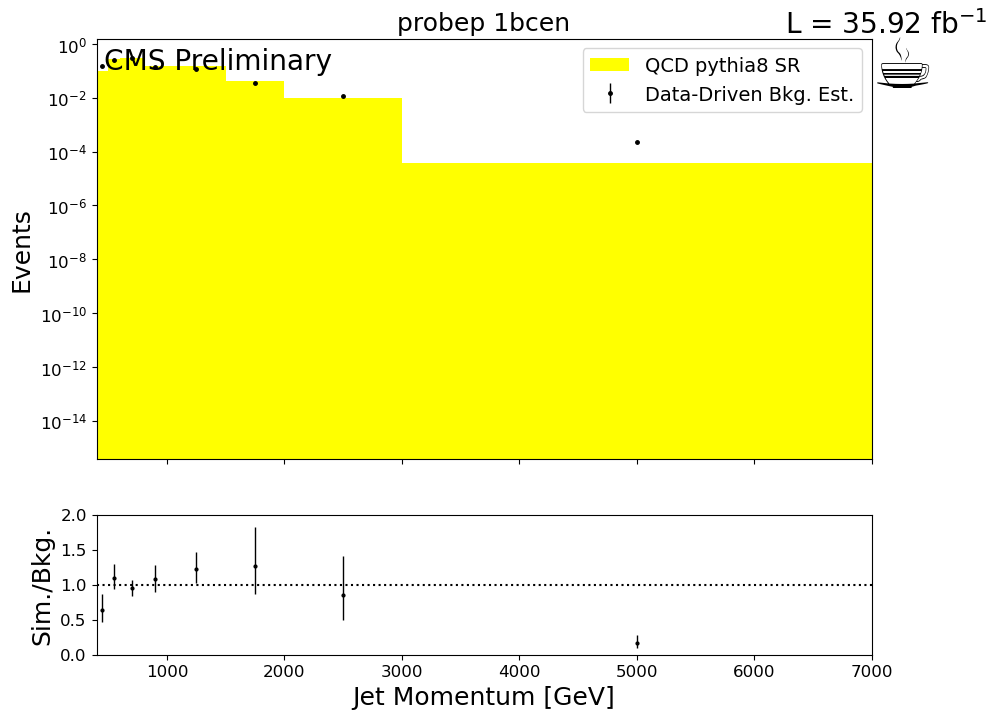

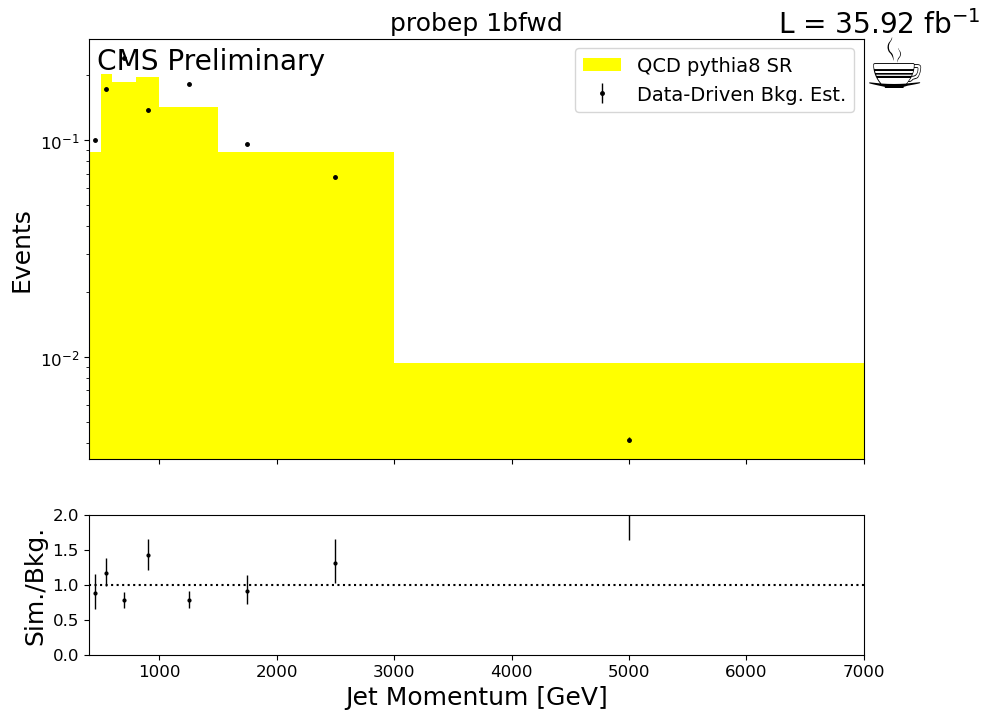

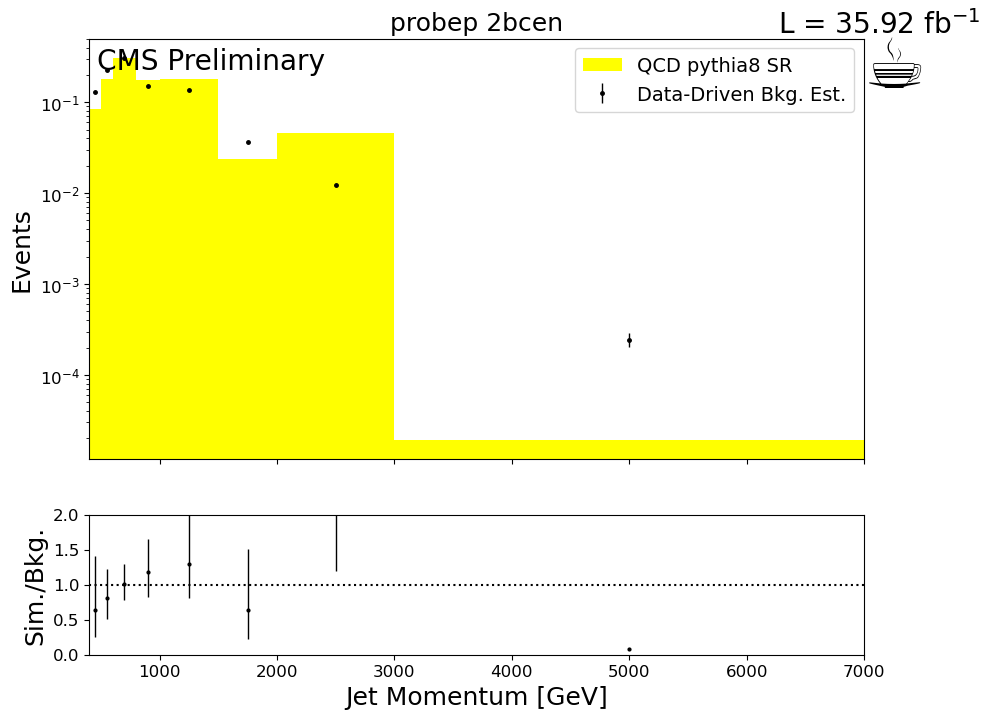

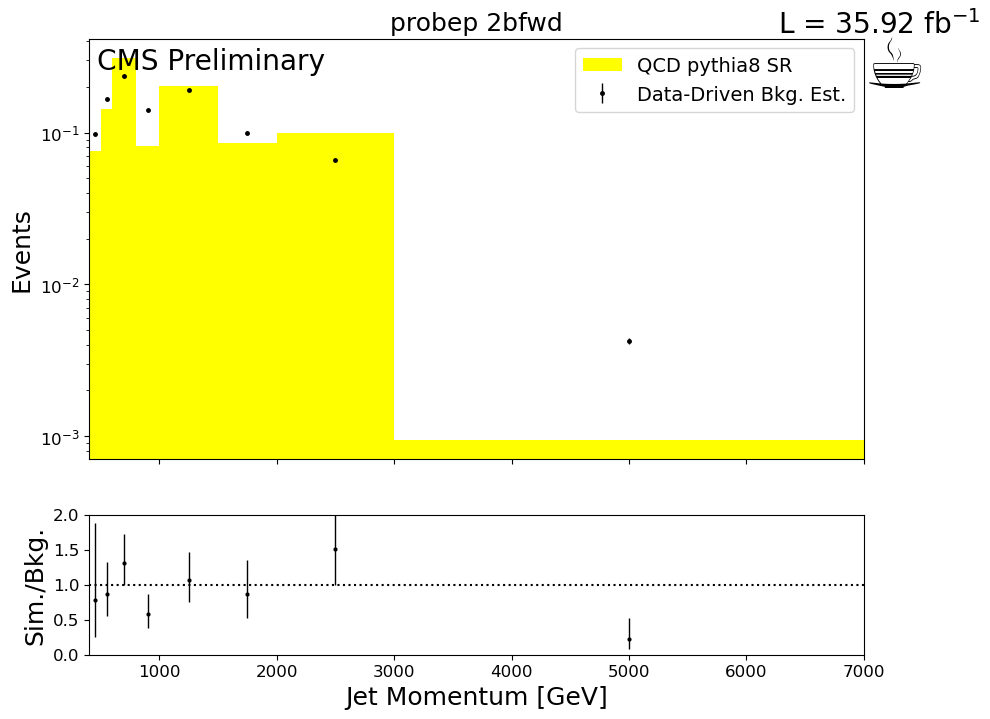

In [13]:
for name in list_of_hists:
    
    if saveOn:
        SaveDirectory = f'{maindirectory}/BkgEstimate/ClosureTest/NormalizedToUnity/{yearDir}{btagDir}{oddir}{btagType}{apvdir}{name}/' # split histograms into subdirectories
        hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    
    for b_y in list_of_bcats:
        
        # ---- Relevant Analysis Categories ---- #
        SignalCategory = hpd.ConvertLabelToInt(label_cats_dict, f'2t{b_y}')
        PretagCategory = hpd.ConvertLabelToInt(label_cats_dict, f'pret{b_y}')
        
        # ---- Plotting Figure Setup ---- #
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })

        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(10,8),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True,
        )
        
        # ---- Data Histogram Objects ---- #
        Observed = LD.AddEraHists(JetHT2016_unweighted, 2016, name, SignalCategory)
        Background = LD.AddEraHists(JetHT2016_weighted, 2016, name, PretagCategory)
        
        # ---- TTbar Hist Objects ---- #
        SMTTbar =  LM.ScaledTTbar(TTbar2016_unweighted, 2016, name, SignalCategory, ttbar2016_sf) # SM TTbar MC in Signal Region 
        ExtraTTbar = LM.ScaledTTbar(TTbar2016_weighted, 2016, name, PretagCategory, ttbar2016_sf) # Mistag Weighted TTbar MC (To Remove Double Counting)
        
        # =============================================================================================================================== #
        
        # ---- Add SM ttbar MC to background ---- #
        Background += (SMTTbar) # Include signal region SM ttbar contribution to NTMJ for the complete background estimate
        
        # ---- Remove excess events ---- #
        ExtraTTbar *= -1.0 # Scaled as negative to subtract when adding histogram in next step
        Background += (ExtraTTbar) # ttbar contamination subtraction from background estimate 
        
        # =============================================================================================================================== #
        
        # -- QCD MC -- #
        QCD_hist = QCD2016_weighted['preVFP'][name]['UL16preVFP_QCD', SignalCategory, :]*qcd2016_sf['preVFP']\
                 + QCD2016_weighted['postVFP'][name]['UL16postVFP_QCD', SignalCategory, :]*qcd2016_sf['postVFP']

        # QCD_hist *= qcd2016_sf #scaled according to luminosity 
        QCD_hist += SMTTbar
        
        # ---- Extract both the estimate and QCD events from histograms ---- #
        NtotalQCD = np.sum(QCD_hist.view().value)
        NtotalData = np.sum(Background.view().value)
        
        # ---- Normalize to Unity (compare shape) ---- #
        if NtotalQCD > 0.:
            QCD_hist *= (1.0/NtotalQCD)
        else:
            QCD_hist *= 0.
        if NtotalData > 0.:
            Background *= (1.0/NtotalData)
        else:
            Background *= 0.


        # ---- Plot Histograms (Comment out whatever you don't want included in the figure and/or root file) ---- #
        QCDPlot = QCD_hist.plot1d(ax=ax, histtype='fill', color='yellow')
        BackgroundPlot = Background.plot1d(ax=ax, histtype='errorbar', marker='.', markersize=5., color='k')
#         TTbarPlot = TTbar_2016_wgt_forplot.plot1d(ax=ax, histtype='fill', color='r')
        
        # plt.ylim(bottom = .1, top = 10**4)

        ax.set_yscale('log')
        # ax.set_ylim(bottom=1.0)
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(name + ' ' + b_y)

        #---- Plot Ratio ----#
        hpd.plotratio(QCD_hist, Background, ax = rax, histtype='errorbar', marker='.', markersize=4., color='k')
        
        l1 = [r'QCD pythia8 SR', r'Data-Driven Bkg. Est.']
        legtitle1 = ax.legend(labels=l1, fontsize='medium')
        
        
        rax.set_ylabel('Sim./Bkg.')
        rax.axhline(y=1, color='k', linestyle=':')
        rax.set_ylim(0,2)
        
        # ---- Axis Options ---- #
        hpd.AnalysisAxes(name, rax)
        
        # ---- Labeling ---- #
        hpd.AnalysisLabels(Lum2016, ax)
        
        # ---- Saving Histograms ---- #
        if saveOn:
            filename = 'BkgEst_' + name + '' + Unc + '_' + b_y + '_Closure.png'
            plt.savefig(SaveDirectory+filename, bbox_inches="tight")
            print('\n' + SaveDirectory + filename)


# Analysis Plots with Data Driven Background Estimate

### Plotting Options

In [14]:
apvdir = '' #APVDir['preVFP']
DataOutName = f'{maindirectory}/BkgEstimate/{yearDir}{btagDir}{oddir}{btagType}{apvdir}SignalRegionOutput.txt'
filler = 'w'
PlotType = 'log'
saveOn = False

# list_of_hists = ['ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep']
list_of_hists = ['ttbarmass']

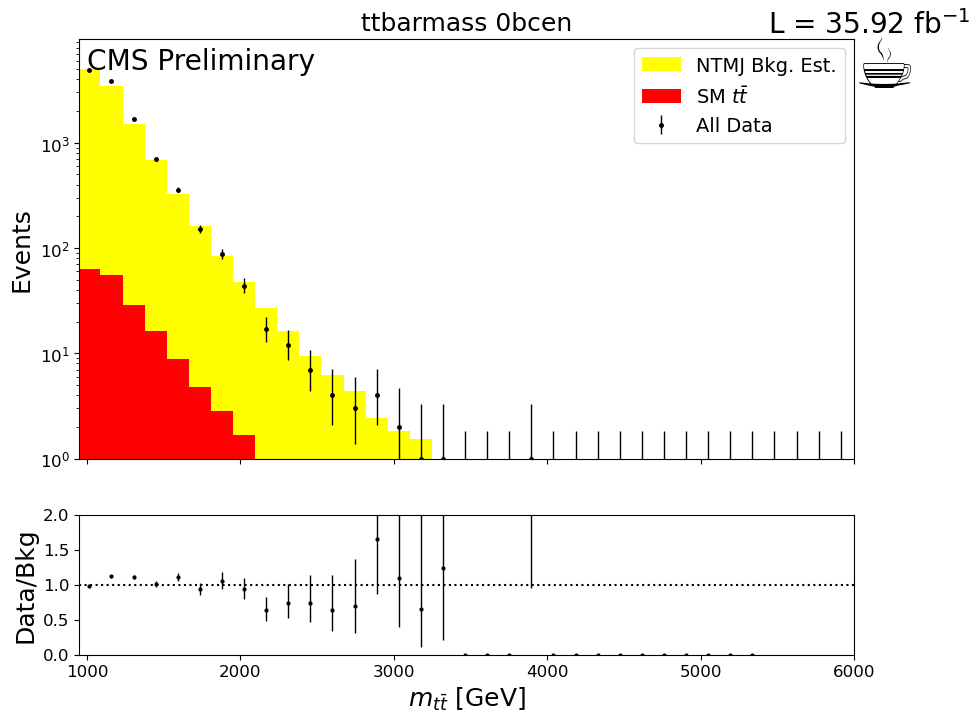

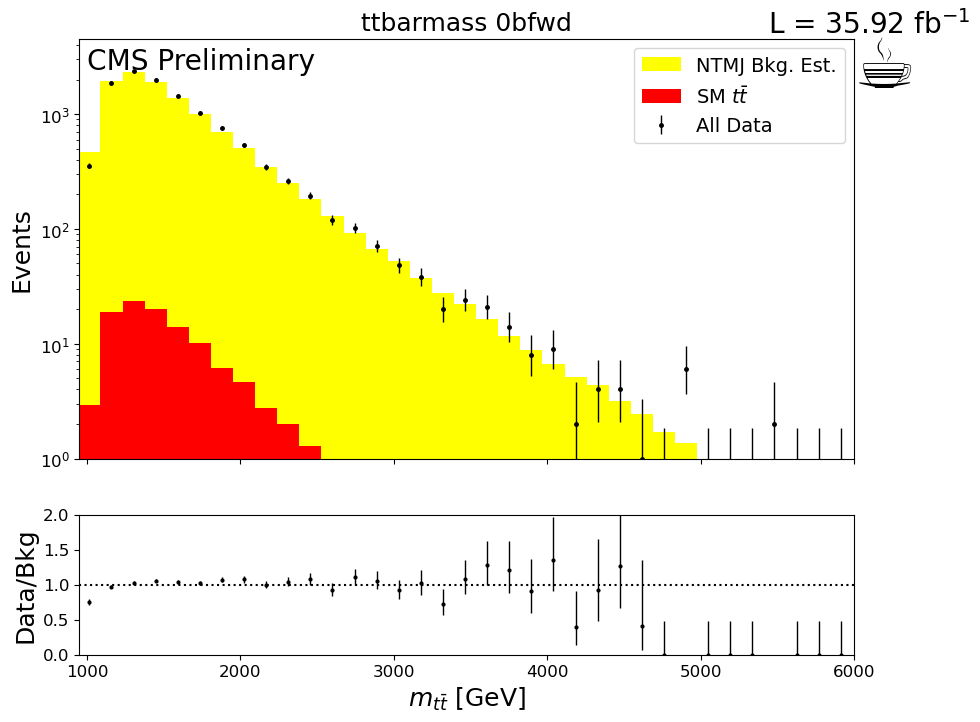

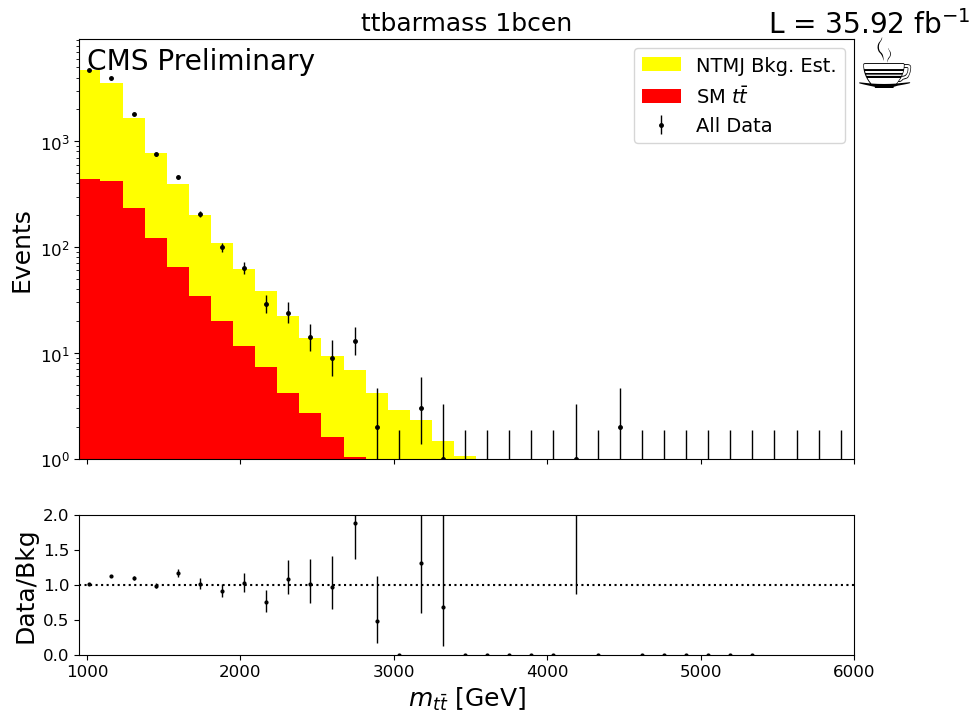

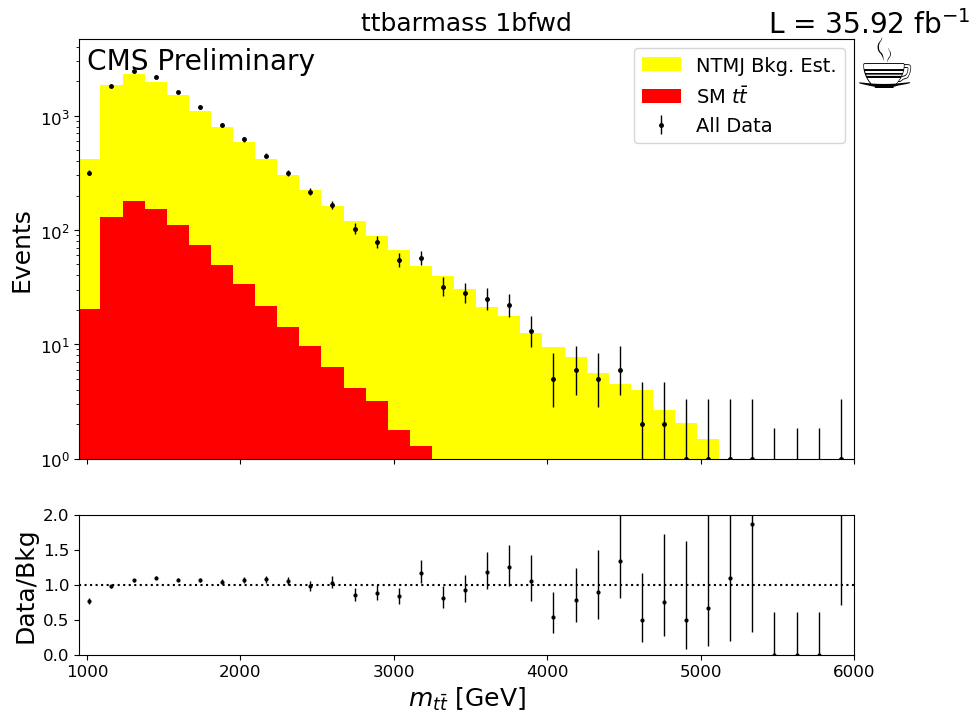

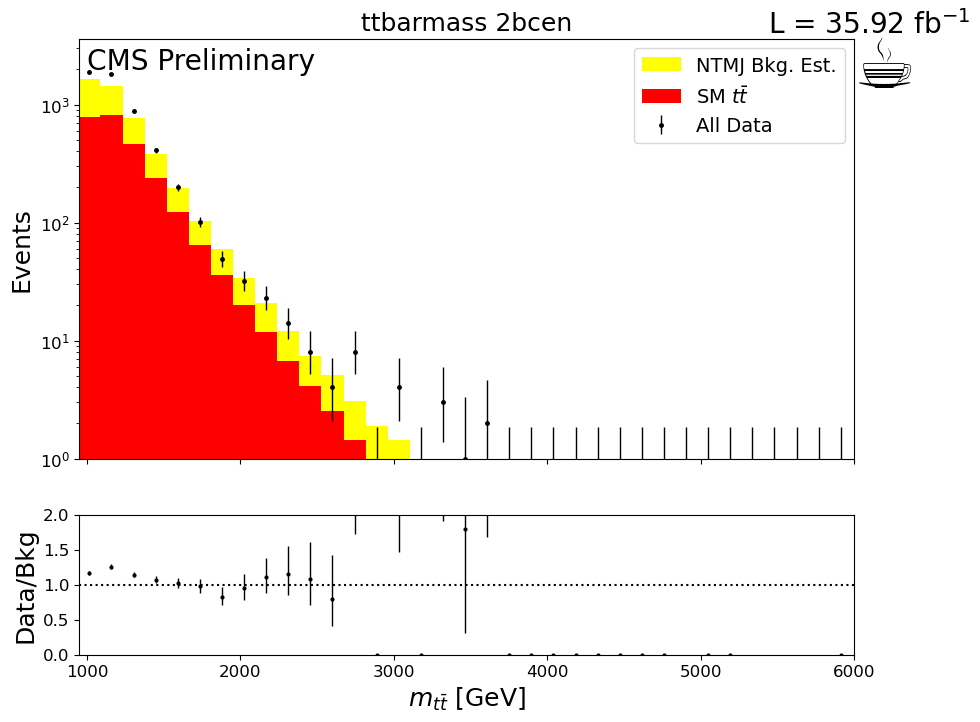

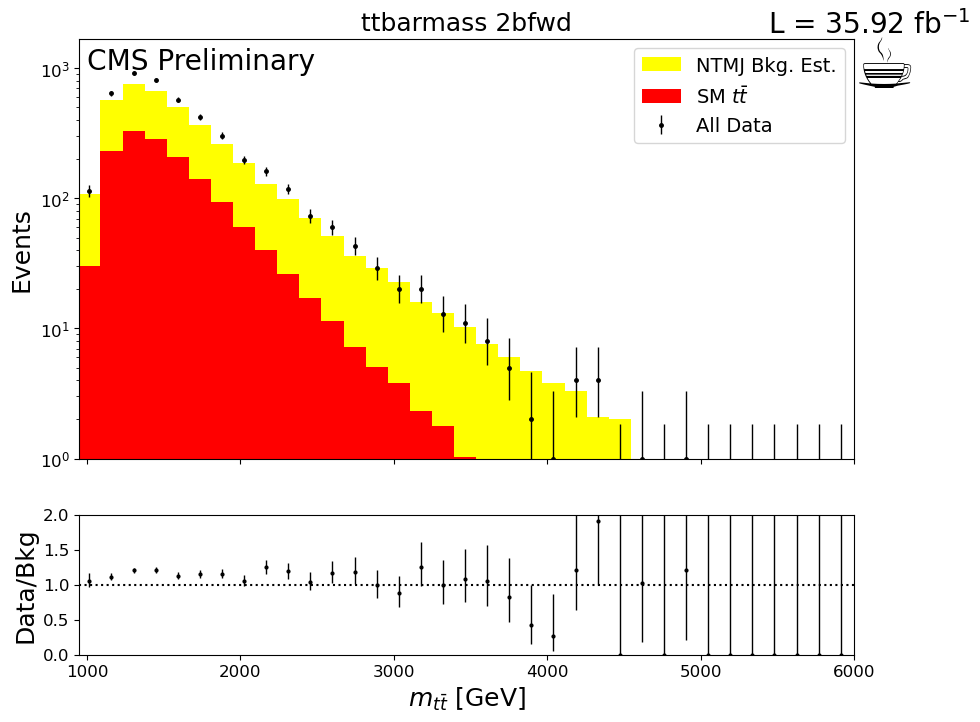

In [15]:
""" -------------------------- Comparing Background Estimate to Unweighted Data (One Histogram) ---------------------- """
""" --------------- Background: t tagged probe jet from data weighted by mistag (weighted pret region) --------------- """
""" --------------------- Data: Unweighted Data from the Signal Region (unweighted 2t tag region) -------------------- """
count = 0

for name in list_of_hists:
    
    if saveOn:
        SaveDirectory = f'{maindirectory}/BkgEstimate/{yearDir}{btagDir}{oddir}{btagType}{apvdir}{name}/{PlotType}/' # split histograms into subdirectories
        hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    
    for b_y in list_of_bcats:
        
        # ---- Relevant Analysis Categories ---- #
        SignalCategory = hpd.ConvertLabelToInt(label_cats_dict, f'2t{b_y}')
        PretagCategory = hpd.ConvertLabelToInt(label_cats_dict, f'pret{b_y}')
        
        # ---- Plotting Figure Setup ---- #
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })

        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(10,8),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True,
        )
        # ---- Data Histogram Objects ---- #
        Observed = LD.AddEraHists(JetHT2016_unweighted, 2016, name, SignalCategory)
        Background = LD.AddEraHists(JetHT2016_weighted, 2016, name, PretagCategory)
        
        # ---- TTbar Hist Objects ---- #
        SMTTbar =  LM.ScaledTTbar(TTbar2016_unweighted, 2016, name, SignalCategory, ttbar2016_sf) # SM TTbar MC in Signal Region 
        ExtraTTbar = LM.ScaledTTbar(TTbar2016_weighted, 2016, name, PretagCategory, ttbar2016_sf) # Mistag Weighted TTbar MC (To Remove Double Counting)
        
        # =============================================================================================================================== #
        
        # ---- Add SM ttbar MC to background ---- #
        Background += (SMTTbar) # Include signal region SM ttbar contribution to NTMJ for the complete background estimate
        
        # ---- Remove excess events ---- #
        ExtraTTbar *= -1.0 # Scaled as negative to subtract when adding histogram in next step
        Background += (ExtraTTbar) # ttbar contamination subtraction from background estimate 
        
        # =============================================================================================================================== #
        
        # # ---- Shrink current axis by 10% ---- 3
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.9, box.height * 0.9])

        # ---- Plot Histograms ---- #
        ObservedPlot = Observed.plot1d(ax=ax, histtype='errorbar', marker='.', markersize=5., color='k')
        BackgroundPlot = Background.plot1d(ax=ax, histtype='fill', color='yellow')
        TTbarPlot = SMTTbar.plot1d(ax=ax, histtype='fill', color='r')
        
        NtotalObserved = np.sum(Observed.view().value)
        NtotalBackground = np.sum(Background.view().value)
        NtotalTTbar = np.sum(SMTTbar.view().value)
        
        # ---- Fill text file with event counts ---- #
        if count > 0:
            filler = 'a'
        if count < 6: # Print number of events for each category once
            with open(DataOutName, filler) as f:
                print(f'\t\t{b_y}\n===================================================', file=f)
                print('TTbar     =', '%10i'% NtotalTTbar,      file=f)
                print('Bkg. Est. =', '%10i'% NtotalBackground, file=f)
                print('Observed  =', '%10i'% NtotalObserved,   file=f)
                print('\n', file=f)
                count += 1
                
        ax.set_yscale(PlotType)
        ax.set_ylim(bottom=1.)
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(name + ' ' + b_y)

        #---- Plot Ratio ----#
        hpd.plotratio(Observed, Background, ax = rax, histtype='errorbar', marker='.', markersize=4., color='k')
        
        l1 = [r'NTMJ Bkg. Est.', r'SM $t\bar{t}$', r'All Data']
        legtitle1 = ax.legend(labels=l1, fontsize='medium')
        
        
        rax.set_ylabel('Data/Bkg')
        rax.axhline(y=1, color='k', linestyle=':')
        rax.set_ylim(0,2)
        
        # ---- Axis Options ---- #
        hpd.AnalysisAxes(name, rax)
        
        # ---- Labeling ---- #
        hpd.AnalysisLabels(Lum2016, ax)
        
        # ---- Saving Histograms ---- #
        if saveOn:
            filename = 'BkgEst_' + name + '' + Unc + '_' + b_y + '.png'
            plt.savefig(SaveDirectory+filename, bbox_inches="tight")
            print('\n' + SaveDirectory + filename)


# Analysis Plots with Data Driven Background Estimate and Z' Signal

### Plotting Options

In [16]:
apvdir = ''  #APVDir['preVFP']
DataOutName = f'{maindirectory}/BkgEstimate/{yearDir}{btagDir}{oddir}{btagType}{apvdir}SignalRegionOutputWithZPrimeDM.txt'
filler = 'w'
PlotType = 'log'
saveOn = False
rootOn = False

# list_of_hists = ['ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep']
list_of_hists = ['ttbarmass']
DM_hist = {}

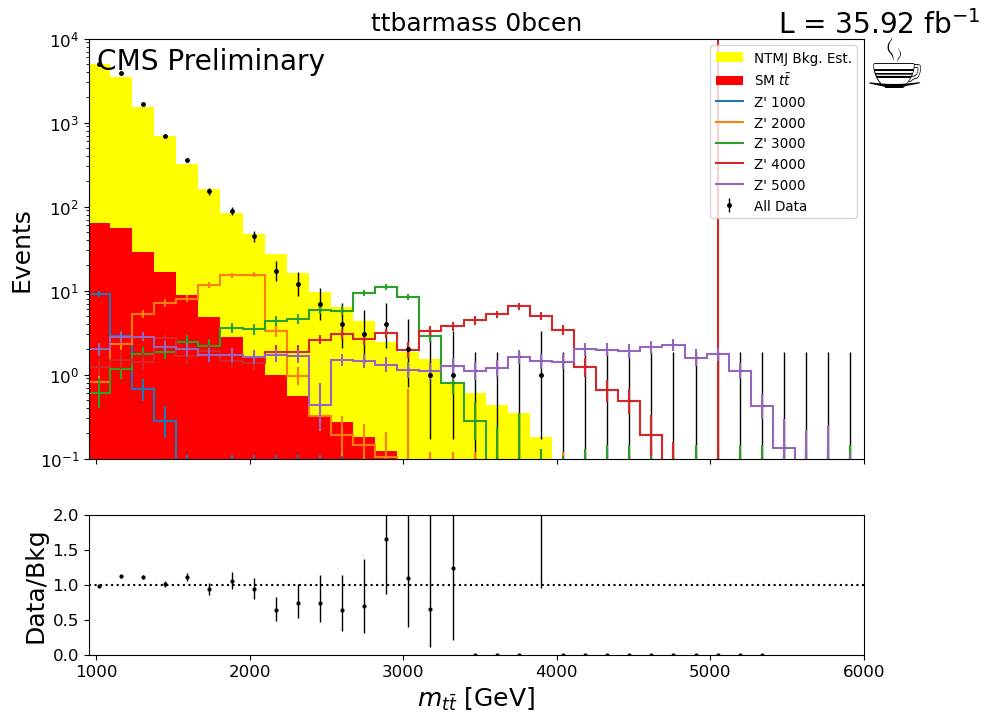

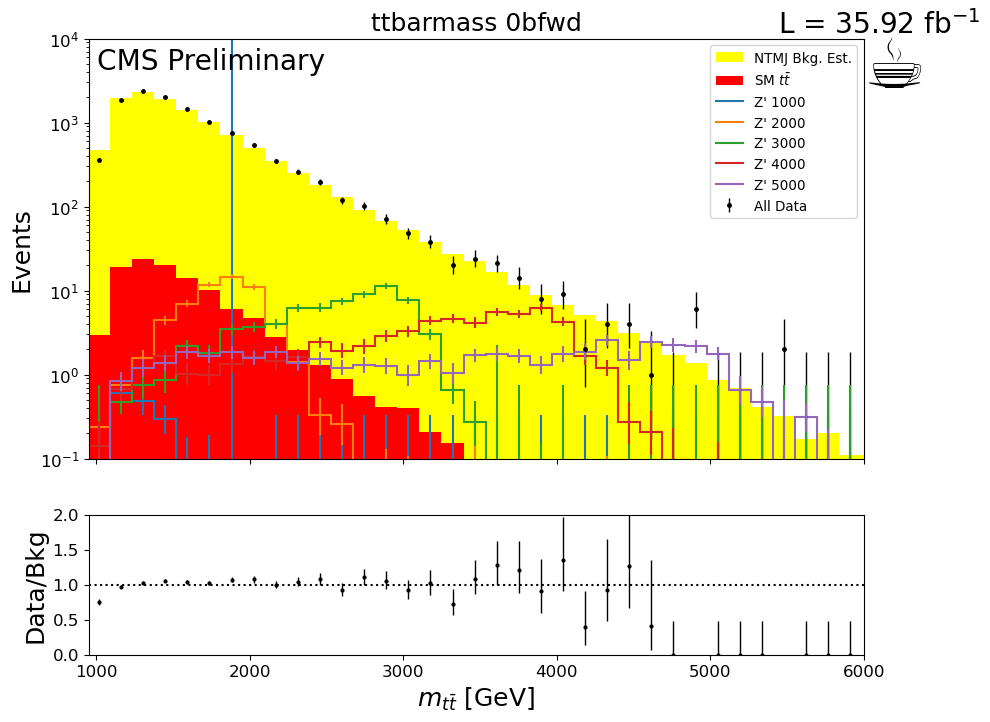

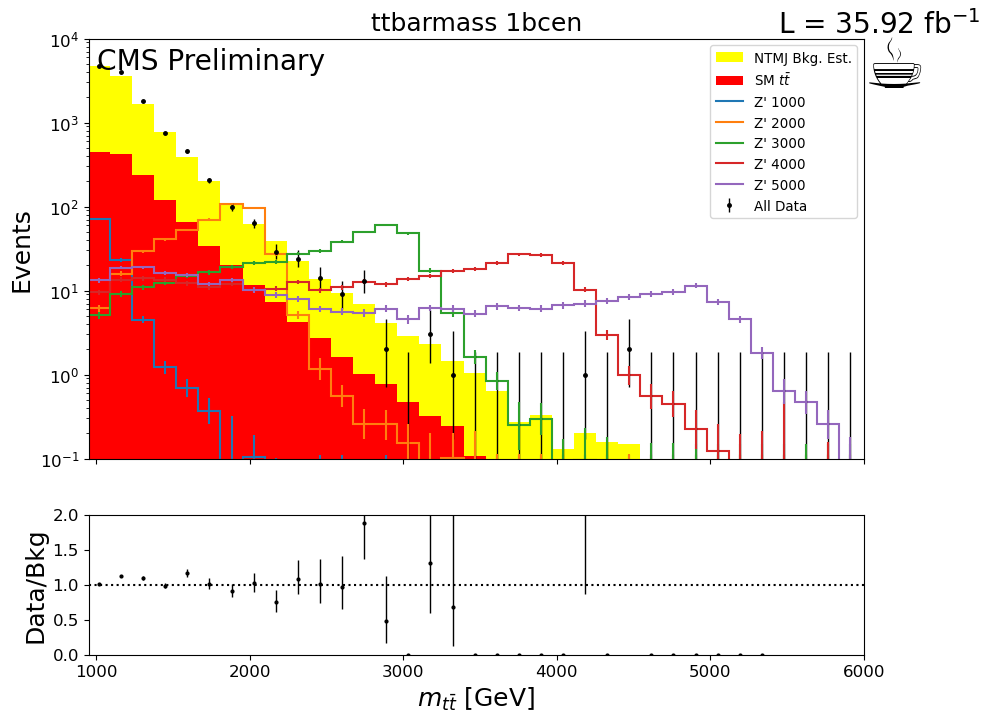

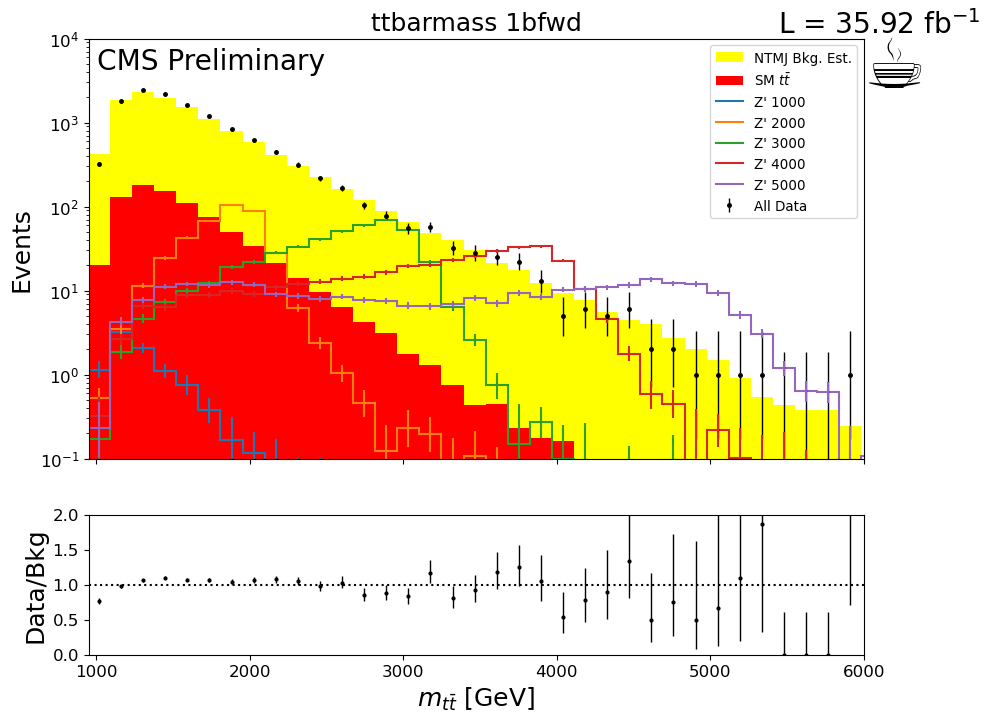

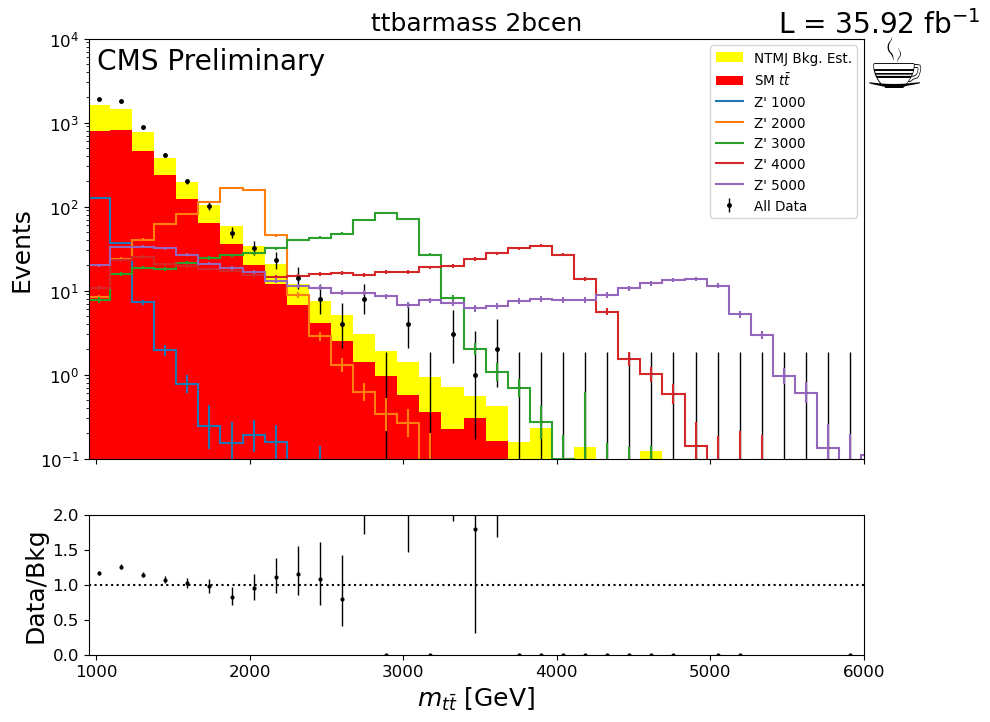

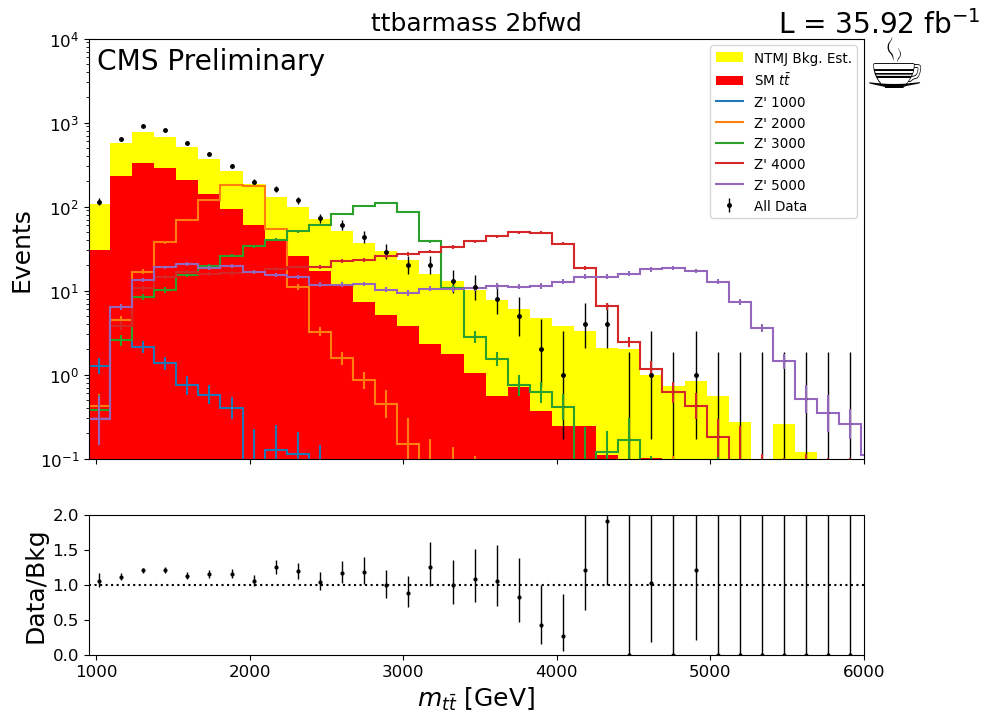

In [17]:
""" -------------------------- Comparing Background Estimate to Unweighted Data (One Histogram) ---------------------- """
""" --------------- Background: t tagged probe jet from data weighted by mistag (weighted pret region) --------------- """
""" --------------------- Data: Unweighted Data from the Signal Region (unweighted 2t tag region) -------------------- """

count = 0

if rootOn:
    SaveDirectoryRootFiles = f'{maindirectory}/BkgEstimate/RootFiles/{yearDir}{btagDir}{oddir}{btagType}{apvdir}/'
    hpd.DoesDirectoryExist(SaveDirectoryRootFiles)

for name in list_of_hists:
    
    if saveOn:
        SaveDirectory = f'{maindirectory}/BkgEstimate/{yearDir}{btagDir}{oddir}{btagType}{apvdir}{name}/{PlotType}/' # split histograms into subdirectories
        hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    
    if rootOn:
        RootFile = f'{SaveDirectoryRootFiles}TTbarRes_0l_{name}.root' # Root file for each histogram type (ttbarmass, jetpt, etc...)
        root_output = uproot.recreate(RootFile)

    for b_y in list_of_bcats:
        
        # ---- Relevant Analysis Categories ---- #
        SignalCategory = hpd.ConvertLabelToInt(label_cats_dict, f'2t{b_y}')
        PretagCategory = hpd.ConvertLabelToInt(label_cats_dict, f'pret{b_y}')
        
        # ---- Plotting Figure Setup ---- #
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })

        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(10,8),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True,
        )
        
        # ---- Data Histogram Objects ---- #
        Observed = LD.AddEraHists(JetHT2016_unweighted, 2016, name, SignalCategory)
        Background = LD.AddEraHists(JetHT2016_weighted, 2016, name, PretagCategory)

        # ---- TTbar Hist Objects ---- #
        SMTTbar =  LM.ScaledTTbar(TTbar2016_unweighted, 2016, name, SignalCategory, ttbar2016_sf) # SM TTbar MC in Signal Region 
        ExtraTTbar = LM.ScaledTTbar(TTbar2016_weighted, 2016, name, PretagCategory, ttbar2016_sf) # Mistag Weighted TTbar MC (To Remove Double Counting)
        
        # =============================================================================================================================== #
        
        # ---- Add SM ttbar MC to background ---- #
        Background += (SMTTbar) # Include signal region SM ttbar contribution to NTMJ for the complete background estimate
        
        # ---- Remove excess events ---- #
        ExtraTTbar *= -1.0 # Scaled as negative to subtract when adding histogram in next step
        Background += (ExtraTTbar) # ttbar contamination subtraction from background estimate 
        
        # =============================================================================================================================== #

        # ---- MC Signal for Histograms ---- #
        for mass in range(1000, 5500, 1000):
            DM_hist[str(mass)] = DM2016_weighted[str(mass)+'_preVFP'][name][f'UL16preVFP_DM{str(mass)}', SignalCategory, :]*DM2016_sf[str(mass)+'_preVFP']\
                               + DM2016_weighted[str(mass)+'_postVFP'][name][f'UL16postVFP_DM{str(mass)}', SignalCategory, :]*DM2016_sf[str(mass)+'_postVFP']

        # ---- Plot Histograms ---- #
        ObservedPlot = Observed.plot1d(ax=ax, histtype='errorbar', marker='.', markersize=5., color='k')
        BackgroundPlot = Background.plot1d(ax=ax, histtype='fill', color='yellow')
        TTbarPlot = SMTTbar.plot1d(ax=ax, histtype='fill', color='r')
        for mass in range(1000, 5500, 1000):
            DM_hist[str(mass)].plot1d(ax=ax, histtype='step')
        
        # ---- Fill text file with event counts ---- #
        NtotalObserved = np.sum(Observed.view().value)
        NtotalBackground = np.sum(Background.view().value)
        NtotalTTbar = np.sum(SMTTbar.view().value)
        
        if count > 0:
            filler = 'a'
        if count < 6: # Print number of events for each category once
            with open(DataOutName, filler) as f:
                print(f'\t\t{b_y}\n===================================================', file=f)
                print('TTbar     =', '%10i'% NtotalTTbar,      file=f)
                print('Bkg. Est. =', '%10i'% NtotalBackground, file=f)
                print('Observed  =', '%10i'% NtotalObserved,   file=f)
                print('\n', file=f)
                count += 1
                
        ax.set_yscale(PlotType)
        # ax.set_ylim(bottom=0.1)
        ax.set_ylim(bottom=0.1, top=10**4)
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(name + ' ' + b_y)

        #---- Plot Ratio ----#
        hpd.plotratio(Observed, Background, ax = rax, histtype='errorbar', marker='.', markersize=4., color='k')
        
        l1 = [r'NTMJ Bkg. Est.', r'SM $t\bar{t}$']
        for mass in range(1000, 5500, 1000):
            l1.append(f'Z\' {str(mass)}')
        l1.append(r'All Data')
        legtitle1 = ax.legend(labels=l1, fontsize='x-small')
        
        
        rax.set_ylabel('Data/Bkg')
        rax.axhline(y=1, color='k', linestyle=':')
        rax.set_ylim(0,2)
        
        # ---- Axis Options ---- #
        hpd.AnalysisAxes(name, rax)
        
        # ---- Labeling ---- #
        hpd.AnalysisLabels(Lum2016, ax)
        
        # ---- Saving Histograms ---- #
        if saveOn:
            filename = 'BkgEst_withZprimeDM' + name + '' + Unc + '_' + b_y + '.png'
            plt.savefig(SaveDirectory+filename, bbox_inches="tight")
            print('\n' + SaveDirectory + filename)
        if rootOn:
            root_output[f'Data_{b_y[2:]}{b_y[:-3]}'] = Observed
            root_output[f'BkgEst_{b_y[2:]}{b_y[:-3]}'] = Background_ModMass_Corrected
            root_output[f'TTbar_{b_y[2:]}{b_y[:-3]}'] = SMTTbar
            for mass in range(1000, 5500, 1000):
                root_output[f'ZPrimeDM{str(mass)}_{b_y[2:]}{b_y[:-3]}'] = DM_hist[str(mass)]
    if rootOn:    
        root_output.close()

# Analysis Plots with Data Driven Background Estimate and RS$_{KK}$ Gluon Signals

### Plotting Options

In [18]:
apvdir = ''#APVDir['preVFP']
count = 0
DataOutName = f'{maindirectory}/BkgEstimate/{yearDir}{btagDir}{oddir}{btagType}{apvdir}SignalRegionOutputWithRSGluon.txt'
filler = 'w'
PlotType = 'log'
saveOn = False
rootOn = False

# list_of_hists = ['ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep']
list_of_hists = ['ttbarmass']
RSGluon_hist = {}

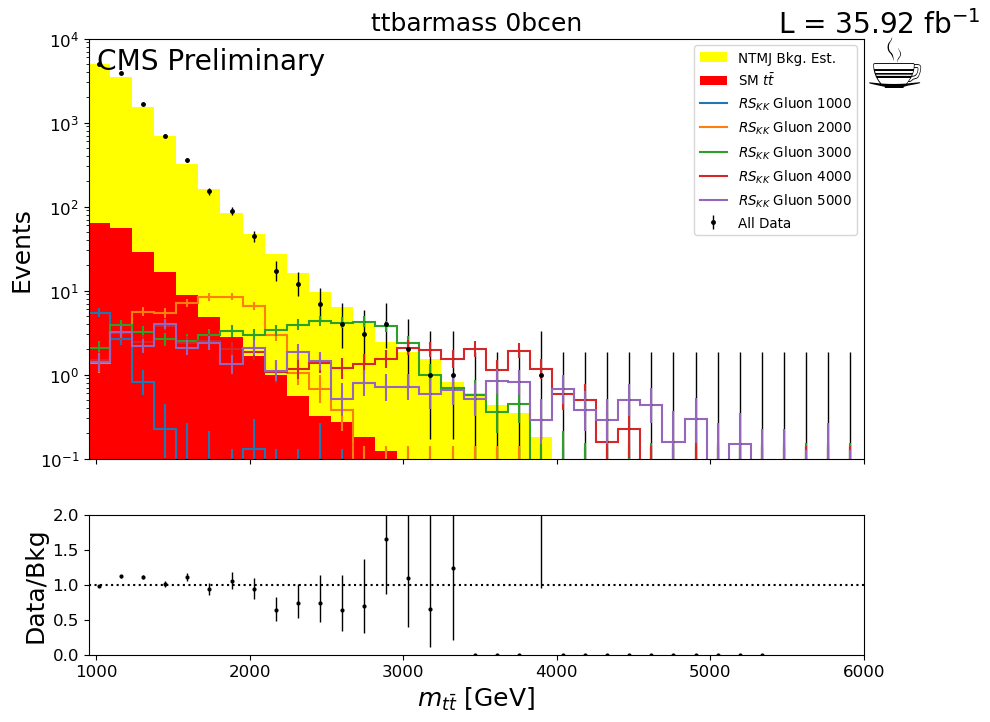

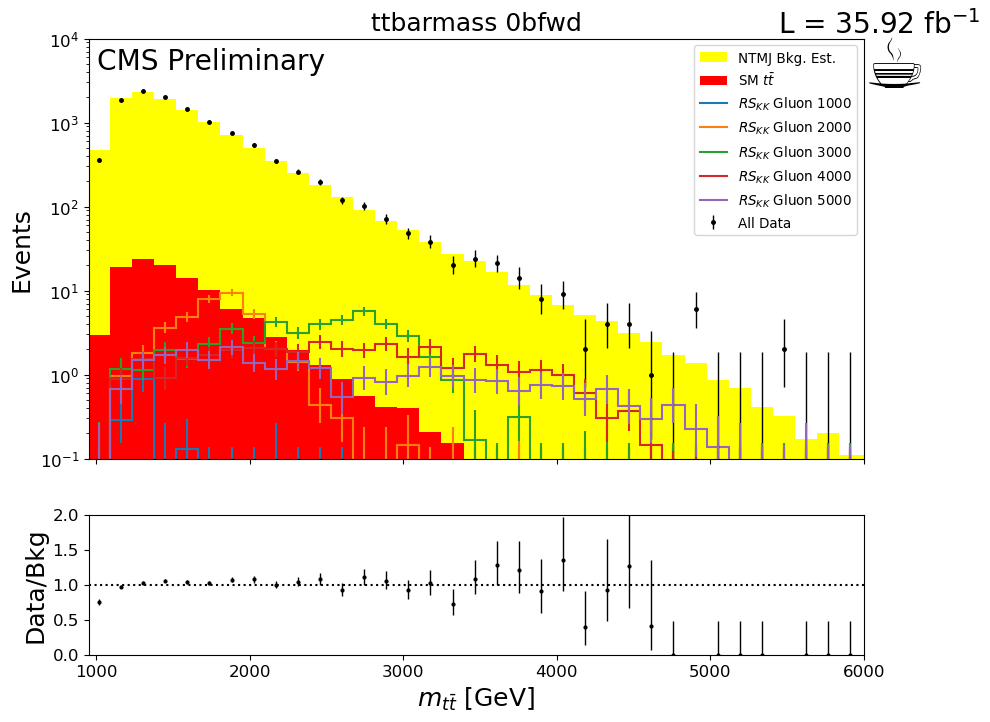

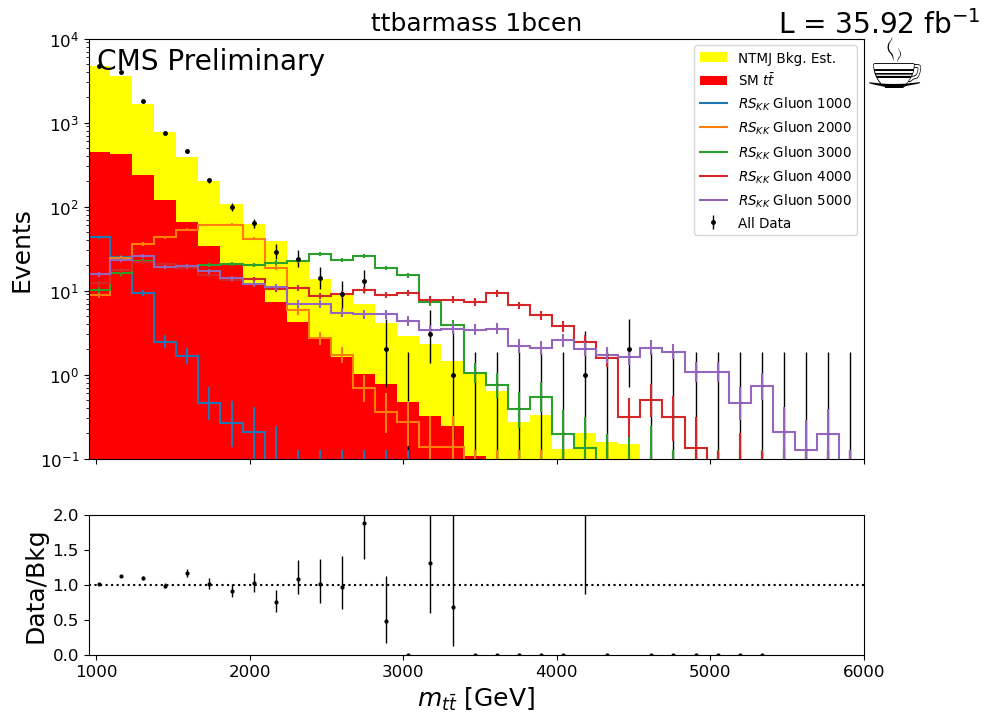

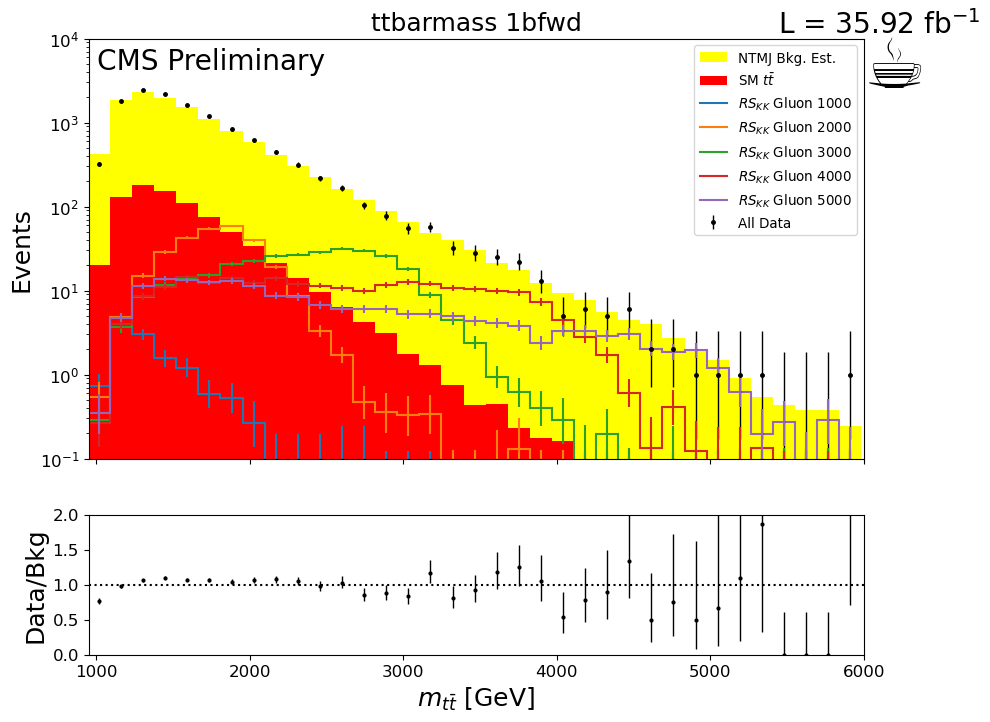

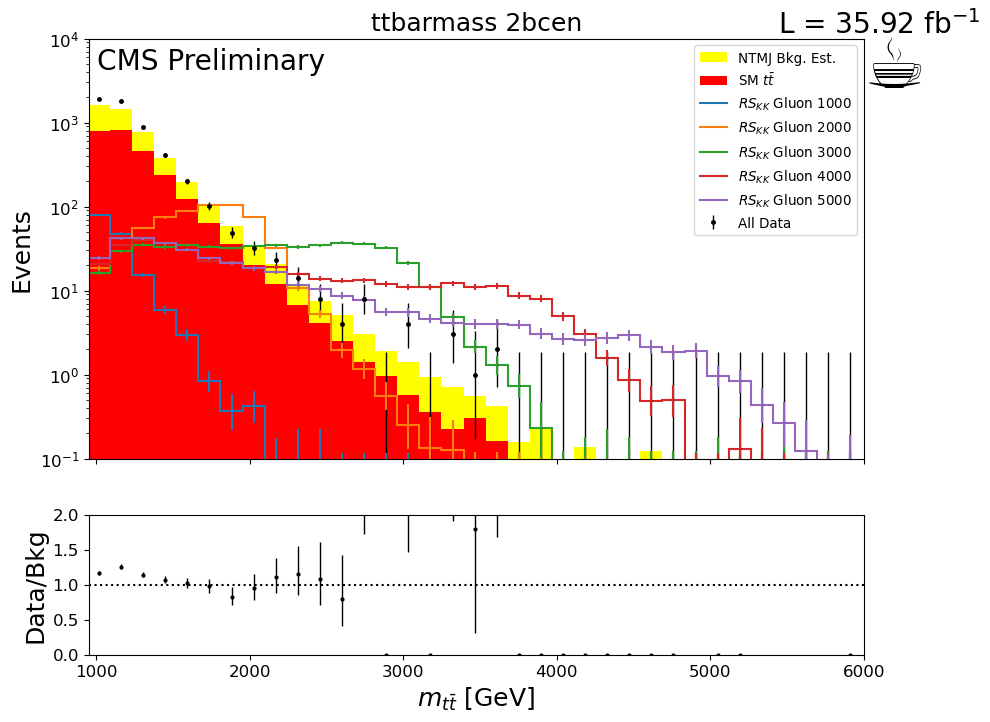

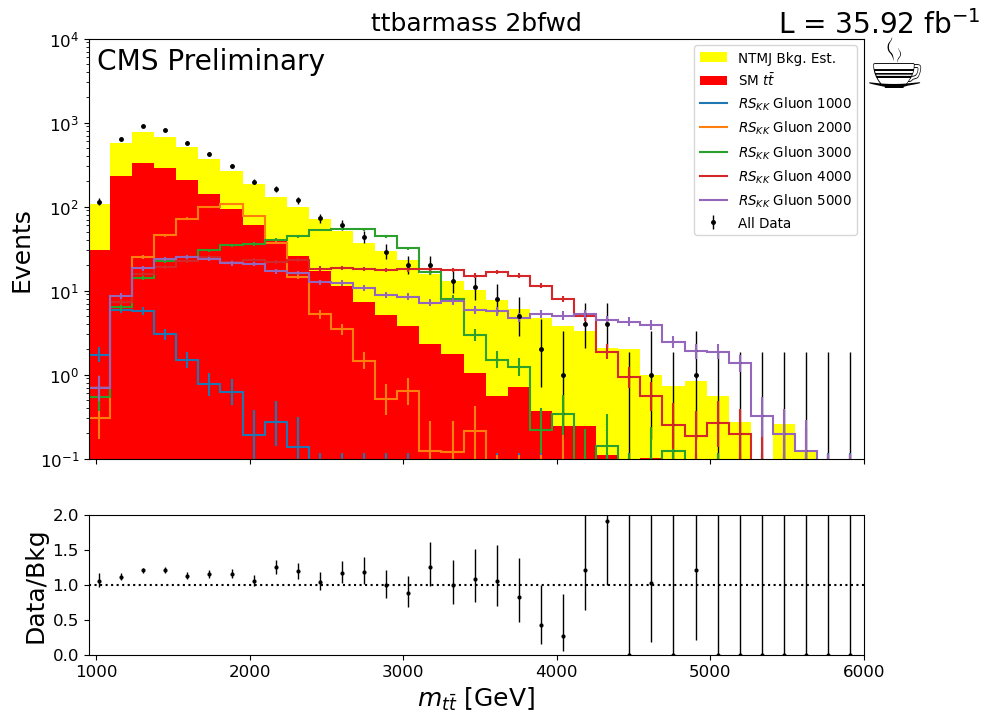

In [19]:
""" -------------------------- Comparing Background Estimate to Unweighted Data (One Histogram) ---------------------- """
""" --------------- Background: t tagged probe jet from data weighted by mistag (weighted pret region) --------------- """
""" --------------------- Data: Unweighted Data from the Signal Region (unweighted 2t tag region) -------------------- """

count = 0

if rootOn:
    SaveDirectoryRootFiles = f'{maindirectory}/BkgEstimate/RootFiles/{yearDir}{btagDir}{oddir}{btagType}{apvdir}/'
    hpd.DoesDirectoryExist(SaveDirectoryRootFiles)

for name in list_of_hists:
    
    if saveOn:
        SaveDirectory = f'{maindirectory}/BkgEstimate/{yearDir}{btagDir}{oddir}{btagType}{apvdir}{name}/{PlotType}/' # split histograms into subdirectories
        hpd.DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    
    if rootOn:
        RootFile = f'{SaveDirectoryRootFiles}TTbarRes_0l_{name}.root' # Root file for each histogram type (ttbarmass, jetpt, etc...)
        root_output = uproot.recreate(RootFile)

    for b_y in list_of_bcats:
        
        # ---- Relevant Analysis Categories ---- #
        SignalCategory = hpd.ConvertLabelToInt(label_cats_dict, f'2t{b_y}')
        PretagCategory = hpd.ConvertLabelToInt(label_cats_dict, f'pret{b_y}')
        
        # ---- Plotting Figure Setup ---- #
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })

        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(10,8),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True,
        )
        
        # ---- Data Histogram Objects ---- #
        Observed = LD.AddEraHists(JetHT2016_unweighted, 2016, name, SignalCategory)
        Background = LD.AddEraHists(JetHT2016_weighted, 2016, name, PretagCategory)

        # ---- TTbar Hist Objects ---- #
        SMTTbar =  LM.ScaledTTbar(TTbar2016_unweighted, 2016, name, SignalCategory, ttbar2016_sf) # SM TTbar MC in Signal Region 
        ExtraTTbar = LM.ScaledTTbar(TTbar2016_weighted, 2016, name, PretagCategory, ttbar2016_sf) # Mistag Weighted TTbar MC (To Remove Double Counting)
        
        # =============================================================================================================================== #
        
        # ---- Add SM ttbar MC to background ---- #
        Background += (SMTTbar) # Include signal region SM ttbar contribution to NTMJ for the complete background estimate
        
        # ---- Remove excess events ---- #
        ExtraTTbar *= -1.0 # Scaled as negative to subtract when adding histogram in next step
        Background += (ExtraTTbar) # ttbar contamination subtraction from background estimate 
        
        # =============================================================================================================================== #

        # ---- MC Signal for Histograms ---- #
        for mass in range(1000, 5500, 1000):
            RSGluon_hist[str(mass)] = RSGluon2016_weighted[str(mass)+'_preVFP'][name][f'UL16preVFP_RSGluon{str(mass)}', SignalCategory, :]*RSGluon2016_sf[str(mass)+'_preVFP']\
                                    + RSGluon2016_weighted[str(mass)+'_postVFP'][name][f'UL16postVFP_RSGluon{str(mass)}', SignalCategory, :]*RSGluon2016_sf[str(mass)+'_postVFP']

        # ---- Plot Histograms ---- #
        ObservedPlot = Observed.plot1d(ax=ax, histtype='errorbar', marker='.', markersize=5., color='k')
        BackgroundPlot = Background.plot1d(ax=ax, histtype='fill', color='yellow')
        TTbarPlot = SMTTbar.plot1d(ax=ax, histtype='fill', color='r')
        for mass in range(1000, 5500, 1000):
            RSGluon_hist[str(mass)].plot1d(ax=ax, histtype='step')
        
        # ---- Fill text file with event counts ---- #
        NtotalObserved = np.sum(Observed.view().value)
        NtotalBackground = np.sum(Background.view().value)
        NtotalTTbar = np.sum(SMTTbar.view().value)
        
        if count > 0:
            filler = 'a'
        if count < 6: # Print number of events for each category once
            with open(DataOutName, filler) as f:
                print(f'\t\t{b_y}\n===================================================', file=f)
                print('TTbar     =', '%10i'% NtotalTTbar,      file=f)
                print('Bkg. Est. =', '%10i'% NtotalBackground, file=f)
                print('Observed  =', '%10i'% NtotalObserved,   file=f)
                print('\n', file=f)
                count += 1
                
        ax.set_yscale(PlotType)
        # ax.set_ylim(bottom=0.1)
        ax.set_ylim(bottom=0.1, top=10**4)
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(name + ' ' + b_y)

        #---- Plot Ratio ----#
        hpd.plotratio(Observed, Background, ax = rax, histtype='errorbar', marker='.', markersize=4., color='k')
        
        l1 = [r'NTMJ Bkg. Est.', r'SM $t\bar{t}$']
        for mass in range(1000, 5500, 1000):
            l1.append(r'$RS_{KK}$ Gluon '+str(mass))
        l1.append(r'All Data')
        legtitle1 = ax.legend(labels=l1, fontsize='x-small')
        
        
        rax.set_ylabel('Data/Bkg')
        rax.axhline(y=1, color='k', linestyle=':')
        rax.set_ylim(0,2)
        
        # ---- Axis Options ---- #
        hpd.AnalysisAxes(name, rax)
        
        # ---- Labeling ---- #
        hpd.AnalysisLabels(Lum2016, ax)
        
        # ---- Saving Histograms ---- #
        if saveOn:
            filename = 'BkgEst_withRSGluon' + name + '' + Unc + '_' + b_y + '.png'
            plt.savefig(SaveDirectory+filename, bbox_inches="tight")
            print('\n' + SaveDirectory + filename)
        if rootOn:
            root_output[f'Data_{b_y[2:]}{b_y[:-3]}'] = Observed
            root_output[f'BkgEst_{b_y[2:]}{b_y[:-3]}'] = Background_ModMass_Corrected
            root_output[f'TTbar_{b_y[2:]}{b_y[:-3]}'] = SMTTbar
            for mass in range(1000, 5500, 1000):
                root_output[f'RSGluon{str(mass)}_{b_y[2:]}{b_y[:-3]}'] = RSGluon_hist[str(mass)]
    if rootOn:    
        root_output.close()